In [4]:
!pip install torch
!pip install transformers
!pip install numpy
!pip install matplotlib

Lesson 1 - Text Generation
Welcome to Lesson 1.

To access the requirements.txt file, go to File and click on Open.

In this Predibase, Inc lesson, we'll cover the following:

How to load an LLM from HuggingFace?
How to generate a token from the model output tensors?
Prefill and decode: optimizing token generation over multiple steps
I hope you enjoy this course!

In [5]:
#Import required packages
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer


# 1. How to load an LLM from HuggingFace?
# Load the LLM
# You'll use GPT2 throughout this course
model_name = "./models/gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

In [6]:
# Examine the model's architecture
# print(model)
# 2. How to generate a token from the model output tensors?
# Text Generation
# Start by tokenizing the input prompt
prompt = "The quick brown fox jumped over the"
inputs = tokenizer(prompt, return_tensors="pt")
inputs


{'input_ids': tensor([[  464,  2068,  7586, 21831, 11687,   625,   262]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

In [7]:
#Pass the inputs to the model and retrieve the logits to find the most likely next token
with torch.no_grad():
    outputs = model(**inputs)

In [8]:
logits = outputs.logits
print(logits.shape)

last_logits = logits[0, -1, :]
next_token_id = last_logits.argmax()
next_token_id

#Decode the most likely token
tokenizer.decode(next_token_id)

torch.Size([1, 7, 50257])


' fence'

In [9]:
#Print the 10 most likely next words
top_k = torch.topk(last_logits, k=10)
tokens = [tokenizer.decode(tk) for tk in top_k.indices]
tokens

[' fence',
 ' edge',
 ' railing',
 ' wall',
 ' table',
 ' tree',
 ' top',
 ' counter',
 ' ground',
 ' side']

In [10]:

#Concatenate the input and most likely tokens
next_inputs = {
    "input_ids": torch.cat(
        [inputs["input_ids"], next_token_id.reshape((1, 1))],
        dim=1
    ),
    "attention_mask": torch.cat(
        [inputs["attention_mask"], torch.tensor([[1]])],
        dim=1
    ),
}
print(next_inputs["input_ids"],
      next_inputs["input_ids"].shape)
print(next_inputs["attention_mask"],
      next_inputs["attention_mask"].shape)


tensor([[  464,  2068,  7586, 21831, 11687,   625,   262, 13990]]) torch.Size([1, 8])
tensor([[1, 1, 1, 1, 1, 1, 1, 1]]) torch.Size([1, 8])


In [12]:
# 3. Prefill and decode: optimizing token generation over multiple steps
# Text generation helper function
# The following helper function generates the next tokens given a set of input tokens
def generate_token(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id

In [13]:
# Use the helper function to generate multiple tokens in a loop
# Track the time it takes to generate each token
generated_tokens = []
next_inputs = inputs
durations_s = []
for _ in range(10):
    t0 = time.time()
    next_token_id = generate_token(next_inputs)
    durations_s += [time.time() - t0]
    
    next_inputs = {
        "input_ids": torch.cat(
            [next_inputs["input_ids"], next_token_id.reshape((1, 1))],
            dim=1),
        "attention_mask": torch.cat(
            [next_inputs["attention_mask"], torch.tensor([[1]])],
            dim=1),
    }
    
    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)

print(f"{sum(durations_s)} s")
print(generated_tokens)


0.9521126747131348 s
[' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence']


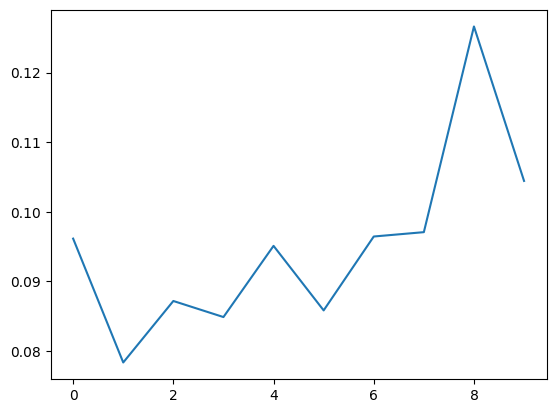

In [14]:
#Plot token generation time
# The x-axis here is the token number
# The y-axis is the time to generate a token in millisenconds (ms)
# Note: Your plot may vary slightly from the one shown in the video, yet it will exhibit a similar pattern.

plt.plot(durations_s)
plt.show()


In [15]:
# Speeding up text generation with KV-caching
# KV-caching is a technique to speed up token generation by storing some of the tensors in the attention head for use in subsequent generation steps

# Modify the generate helper function to return the next token and the key/value tensors
def generate_token_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id, outputs.past_key_values


In [17]:
# Generate 10 tokens using the updated helper function
generated_tokens = []
next_inputs = inputs
durations_cached_s = []
for _ in range(10):
    t0 = time.time()
    next_token_id, past_key_values = \
        generate_token_with_past(next_inputs)
    durations_cached_s += [time.time() - t0]
    
    next_inputs = {
        "input_ids": next_token_id.reshape((1, 1)),
        "attention_mask": torch.cat(
            [next_inputs["attention_mask"], torch.tensor([[1]])],
            dim=1),
        "past_key_values": past_key_values,
    }
    
    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)

print(f"{sum(durations_cached_s)} s")
print(generated_tokens)

0.3856635093688965 s
[' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence']


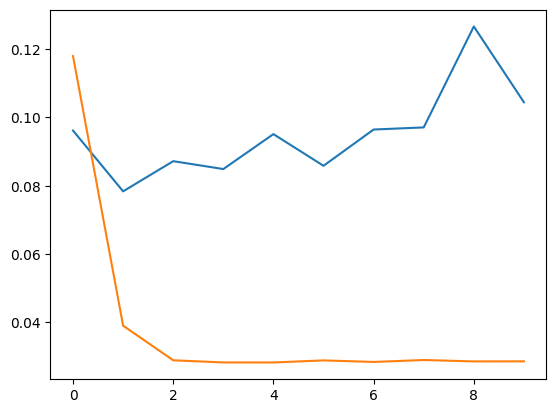

In [18]:
# Compare the execution time for the KV-cache function with the original helper function
# Note: Your plot may vary slightly from the one shown in the video, yet it will exhibit a similar pattern.

plt.plot(durations_s)
plt.plot(durations_cached_s)
plt.show()